Каждый пункт, который предлагается выполнить в рамках домашнего задания, имеет объявленную "цену" в баллах. Максимально возможная сумма – 10 баллов, а с учётом бонусных пунктов – 12 баллов. Выполнять все пункты не обязательно, можно сделать только часть. В большинстве пунктов ожидается, что вы напишете работающий код на Python; иногда надо будет писать комментарии в свободной форме – например, сравнивать несколько подходов к решению одной задачи. Там, где оставлены пустые клетки под ваши ответы, вы можете по своему усмотрению добавлять ещё клетки.

* * *

Эта лабораторная работа посвящена кластеризации. Мы будем работать с рукописными изображениями цифр, научимся их кластеризовать двумя разными методами (иерархическая кластеризация и алгоритм $K$-means), оценивать качество разбиения и выбирать оптимальное число кластеров, а также визуализировать промежуточные результаты.

# 1. Получение данных

Данные, с которыми мы будем работать, доступны в библиотеке scikit-learn (модуль называется `sklearn`) в подмодуле `datasets` через функцию, которая называется `load_digits`. Всего имеется 1797 наблюдений, каждое из них представляет чёрно-белую картинку 8 $\times$ 8 пикселей. Эти картинки – распознанные рукописные цифры от 0 до 9. Образцов написания каждой цифры дано приблизительно поровну, около 180.

Для удобства использования данных каждая картинка "развёрнута" в строку, так что NumPy-массив, в котором хранятся данные, имеет размерность 2 и величину 1797 $\times$ 64 (а не, например, размерность 3 и величину 1797 $\times$ 8 $\times$ 8). Интенсивность цвета в каждом пикселе кодируется целым числом от 0 до 16.

Кроме наблюдений (картинок), известны соответствующие им значения целевой переменной: какую цифру на самом деле изображает каждая картинка. Мы могли бы сразу сформулировать задачу обучения с учителем и предсказывать цифры по картинкам, но для целей этой лабораторной работы мы будем действовать по-другому: сделаем вид, что нам не известны истинные метки классов (т. е. цифры) и даже количество классов, и попробуем сгруппировать данные таким образом, чтобы качество кластеризации оказалось наилучшим, а затем посмотрим, насколько точно полученные кластеры совпадают с группами изображений одинаковых цифр.

**(0.5 балла)** Загрузите данные. Добейтесь, чтобы в переменной `X` оказался массив наблюдений, содержащий 1797 $\times$ 64 числа, а в переменной `y` – массив истинных меток классов, содержащий 1797 чисел.

*Указания:*
- Как загрузить данные, объяснено в справке к функции `load_digits`.
- Размер массива хранится в атрибуте `shape`.

In [21]:
from sklearn.datasets import load_digits


digits = load_digits()
X = digits.data
y = digits.target

**(1 балл)** Визуализируйте первые десять картинок, расположив их на сетке 3 $\times$ 4 (в последнем ряду останутся пустые места). Добейтесь, чтобы фон картинок был белым, а изображения цифр – тёмными.

*Указания:*
- Не забудьте импортировать NumPy и Matplotlib.
- Картинки 8 $\times$ 8 можно либо достать готовыми из объекта, загруженного функцией `load_digits`, либо сделать самостоятельно из строк массива `X`. Во втором случае пользуйтесь методом `reshape`.
- Чтобы изображение не было цветным, можно вызвать функцию `plt.gray`, прежде чем начать рисовать.
- Располагать картинки на сетке умеет функция `plt.subplot`. Ознакомьтесь со справкой к ней.
- По умолчанию число 0 кодирует чёрный цвет, а число 16 – белый цвет. Подумайте, как обратить цвета одной операцией над NumPy-массивом.
- Выводить картинку на экран умеет функция `plt.imshow`. Ознакомьтесь со справкой к ней.
- Если считаете нужным, можете отключить сглаживание – параметр `interpolation` у функции `plt.imshow`.
- Если считаете нужным, можете отключить деления на координатных осях. За это отвечают функции `plt.xticks` и `plt.yticks`.

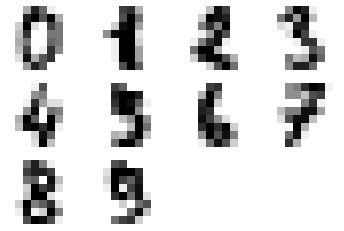

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

MAX_IMG_COUNT = 10
MAX_X_SUBPLOTS = 3
MAX_Y_SUBPLOTS = 4

img_for_visual = X[0 : MAX_IMG_COUNT]

fig, axs = plt.subplots(MAX_X_SUBPLOTS, MAX_Y_SUBPLOTS)

curr_img_count = 0
for i in range(0, MAX_X_SUBPLOTS):
    for j in range (0, MAX_Y_SUBPLOTS):
        axs[i, j].set_axis_off()
        if (curr_img_count < MAX_IMG_COUNT):
            axs[i, j].imshow(img_for_visual[curr_img_count].reshape((8, 8)), cmap=plt.cm.gray_r, interpolation='nearest')
            curr_img_count += 1





# 2. Кластеризация и оценка качества

Мы будем использовать два популярных алгоритма: иерархическую кластеризацию и метод $K$ средних ($K$-means clustering). Эти и другие алгоритмы кластеризации доступны в библиотеке scikit-learn в подмодуле `cluster`. Иерархическая кластеризация называется `AgglomerativeClustering`, а метод $K$ средних – `KMeans`.

Интерфейс у большинства алгоритмов в scikit-learn простой и единообразный:
- Чтобы инициализировать модель, нужно создать экземпляр соответствующего класса со всеми необходимыми параметрами. Например, у кластеризаций единственный обязательный параметр называется `n_clusters`, это количество кластеров, которое мы хотим получить на выходе.
- Инициализированную модель можно обучить, вызвав метод `fit`.
- С помощью обученной модели можно предсказывать, вызывая метод `predict`.

Как видно, этот интерфейс хорош только для задач обучения с учителем, в которых чётко разделены фазы обучения модели и предсказания с её помощью. У кластеризаций зато есть метод `fit_predict`, который разбивает входную выборку на кластеры и сразу же возвращает результаты разбиения.

**(0.5 балла)** Используя каждый из двух методов, иерархическую кластеризацию и $K$ средних, получите разбиение массива `X` на 10 кластеров.

*Указания:*
- Оба раза должен получиться массив из 1797 чисел – номеров кластеров.
- `KMeans` делает несколько (по умолчанию 10) запусков со случайными центрами и из полученных разбиений выводит лучшее в терминах среднего внутрикластерного расстояния. Чтобы улучшить качество предсказаний, можно увеличить число запусков, например, до 100. Это параметр `n_init` в конструкторе.

In [25]:
from sklearn.cluster import AgglomerativeClustering, KMeans

clustering_agglomerative = AgglomerativeClustering(n_clusters=10).fit_predict(X)
clustering_kmean = KMeans(n_clusters=10, n_init=300).fit_predict(X)
print(clustering_agglomerative.shape)
print(clustering_kmean.shape)

(1797,)
(1797,)


**(1 балл)** Визуализируйте центры кластеров, полученных каждым из двух способов. Это опять должны быть картинки на сетке 3 $\times$ 4 с белым фоном и тёмными контурами. Прокомментируйте: какой из двух алгоритмов даёт центры кластеров, больше похожие на типичные начертания цифр?

*Указания:*
- Центр кластера – это среднее по всем наблюдениям, входящим в кластер, т. е. по какому-то набору строк из `X`.
- Чтобы выбрать наблюдения, входящие в кластер номер `i`, используйте индексацию по булевозначной маске. Саму маску можно получить из массива предсказанных номеров кластеров и числа `i` оператором `==`.
- Усреднять NumPy-массив вдоль какой-нибудь из осей умеет функция `np.mean`. Ознакомьтесь со справкой к ней. Нам нужно усреднение по строкам.

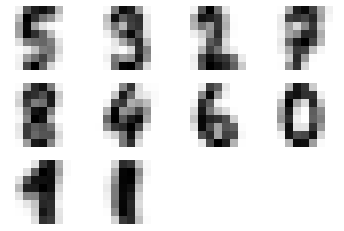

In [75]:
MAX_IMG_COUNT = 10
MAX_X_SUBPLOTS = 3
MAX_Y_SUBPLOTS = 4

X_mean = {}
for i in range(0,10):
    mask_cluster = clustering_agglomerative == i
    X_mean[i] = np.mean(X[mask_cluster], axis=0).reshape((8, 8))  

img_for_visual = X_mean
fig, axs = plt.subplots(MAX_X_SUBPLOTS, MAX_Y_SUBPLOTS)

curr_img_count = 0
for i in range(0, MAX_X_SUBPLOTS):
    for j in range (0, MAX_Y_SUBPLOTS):
        axs[i, j].set_axis_off()
        if (curr_img_count < MAX_IMG_COUNT):
            axs[i, j].imshow(img_for_visual[curr_img_count], cmap=plt.cm.gray_r, interpolation='nearest')
            curr_img_count += 1

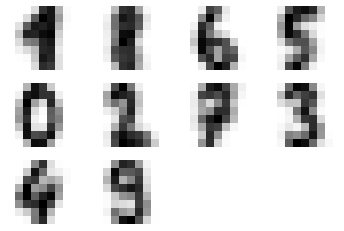

In [76]:
X_mean = {}
for i in range(0,10):
    mask_kmean = clustering_kmean == i
    X_mean[i] = np.mean(X[mask_kmean], axis=0).reshape((8, 8))    

img_for_visual = X_mean
fig, axs = plt.subplots(MAX_X_SUBPLOTS, MAX_Y_SUBPLOTS)

curr_img_count = 0
for i in range(0, MAX_X_SUBPLOTS):
    for j in range (0, MAX_Y_SUBPLOTS):
        axs[i, j].set_axis_off()
        if (curr_img_count < MAX_IMG_COUNT):
            axs[i, j].imshow(img_for_visual[curr_img_count], cmap=plt.cm.gray_r, interpolation='nearest')
            curr_img_count += 1

In [ ]:
I think kmean work better. Only second cluster have bad quality.

В ситуации, когда истинное число кластеров неизвестно, подбирают оптимальное число кластеров. При этом учитывают две величины: внутрикластерное расстояние (чем меньше, тем лучше) и межкластерное расстояние (чем больше, тем лучше). Так как две эти величины не достигают оптимума одновременно, обычно оптимизируют какой-нибудь функционал от них. Один популярный функционал называется "силуэт" (silhouette). Вот как он вычисляется.

Пусть $X$ – множество наблюдений, $M \subset X$ – один из кластеров, на которые оно разбито в результате кластеризации, $\rho$ – метрика на $X$. Выберем какое-нибудь одно наблюдение $x \in M$. Обозначим $a(x)$ среднее расстояние от $x$ до точек $x'$ из того же кластера:
$$
a(x) = \frac{1}{|M| - 1} \sum_{x' \in M,\, x' \ne x} \rho(x,\, x')
$$

Обозначим $b(x)$ минимум средних расстояний от $x$ до точек $x''$ из какого-нибудь другого кластера $N$:
$$
b(x) = \min_{N \ne M} \frac{1}{|N|} \sum_{x'' \in N} \rho(x,\, x'')
$$

Силуэт – это разность межкластерного и внутрикластерного расстояний, нормированная до отрезка $[-1,\, 1]$ и усреднённая по всем наблюдениям:
$$
\frac{1}{|X|} \sum_{x \in X} \frac{b(x) - a(x)}{\max(a(x),\, b(x))}
$$

В scikit-learn силуэт считается функцией `silhouette_score` из подмодуля `metrics`. На вход нужно передать массив наблюдений и результат кластеризации.

**(1.5 балла)** Для числа $K$ от 2 до 20 включительно получите разбиение массива `X` на $K$ кластеров каждым из двух методов. Посчитайте силуэт. Посчитанные значения силуэта сохраните в переменную и визуализируйте в виде графика в координатах: число $K$ – значение силуэта. При каком числе кластеров достигается максимум силуэта?

*Указания:*
- Не забудьте, что функция `range` не захватывает правый конец диапазона.
- Под значения силуэта можно завести два списка: один для иерархической кластеризации, другой для $K$ средних.
- Рисовать графики умеет функция `plt.plot`. Ознакомьтесь со справкой к ней.
- На одной картинке можно разместить несколько графиков, это просто несколько последовательных вызовов `plt.plot`.
- Чтобы добавить легенду (подписи к графикам), можно воспользоваться функцией `plt.legend`. Местоположение легенды контролируется параметром `loc`.
- Чтобы подписать координатные оси, можно воспользоваться функциями `plt.xlabel` и `plt.ylabel`.

In [105]:
from sklearn.metrics import silhouette_score

K = list(range(2,21))
silhouette_kmean = []
silhouette_agglomerative = []

for k in K:
    clustering_agglomerative = AgglomerativeClustering(n_clusters=k).fit_predict(X)
    silhouette_agglomerative.append([k, silhouette_score(X, clustering_agglomerative)])
    
    clustering_kmean = KMeans(n_clusters=k, n_init=100).fit_predict(X)
    silhouette_kmean.append([k, silhouette_score(X, clustering_kmean)])
    

    

silhouette max from agglomerative: 9
silhouette max from kmean: 16


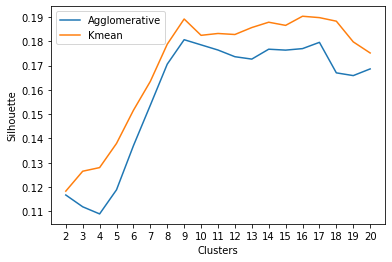

In [119]:
silhouette_agglomerative = np.array(silhouette_agglomerative) 
silhouette_kmean = np.array(silhouette_kmean) 

k_max_agglomerative = silhouette_agglomerative[:,0][np.where(silhouette_agglomerative == np.amax(silhouette_agglomerative[:,1].max()))[0][0]]
k_max_kmean = silhouette_kmean[:,0][np.where(silhouette_kmean == np.amax(silhouette_kmean[:,1].max()))[0][0]]

print('silhouette max from agglomerative: {}'.format(int(k_max_agglomerative)))
print('silhouette max from kmean: {}'.format(int(k_max_kmean)))

plt.plot(silhouette_agglomerative[:,0], silhouette_agglomerative[:,1], label='Agglomerative' )
plt.plot(silhouette_kmean[:,0], silhouette_kmean[:,1], label='Kmean')
plt.xlabel('Clusters')
plt.xticks(K)
plt.ylabel('Silhouette')
plt.legend()

Когда известно "правильное" (в каком-нибудь смысле) разбиение на кластеры, результат кластеризации можно сравнить с ним, используя такие меры, как однородность (homogeneity), полнота (completeness) и их среднее гармоническое – $V$-мера. Определения этих величин довольно громоздкие и основаны на понятии [энтропии распределения вероятностей](https://ru.wikipedia.org/wiki/Информационная_энтропия); подробности излагаются в [этой статье](http://aclweb.org/anthology/D/D07/D07-1043.pdf). На практике достаточно знать, что однородность, полнота и $V$-мера заключены между нулём и единицей – чем больше, тем лучше.

Так как мы знаем, какую цифру на самом деле изображает каждая картинка (это массив `y`), мы можем использовать однородность, полноту и $V$-меру для оценки качества кластеризации. Функции для вычисления этих величин доступны в scikit-learn, в подмодуле `metrics`, под названиями `homogeneity_score`, `completeness_score`, `v_measure_score`. Как вариант, можно использовать функцию `homogeneity_completeness_v_measure`, которая возвращает сразу тройку чисел.

**(1 балл)** Повторите предыдущее задание, используя $V$-меру вместо силуэта. При каком числе кластеров достигается максимум $V$-меры?

In [121]:
from sklearn.metrics import v_measure_score

v_kmean = []
v_agglomerative = []

for k in K:
    clustering_agglomerative = AgglomerativeClustering(n_clusters=k).fit_predict(X)
    v_agglomerative.append([k, v_measure_score(y, clustering_agglomerative)])
    
    clustering_kmean = KMeans(n_clusters=k, n_init=100).fit_predict(X)
    v_kmean.append([k, v_measure_score(y, clustering_kmean)])

V max from agglomerative: 12
V max from kmean: 16


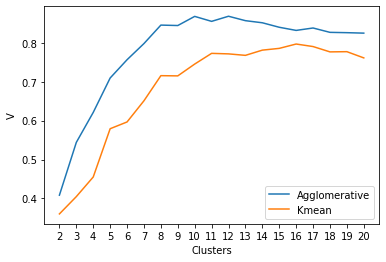

In [124]:
v_agglomerative = np.array(v_agglomerative) 
v_kmean = np.array(v_kmean) 

k_max_agglomerative = v_agglomerative[:,0][np.where(v_agglomerative == np.amax(v_agglomerative[:,1].max()))[0][0]]
k_max_kmean = v_kmean[:,0][np.where(v_kmean == np.amax(v_kmean[:,1].max()))[0][0]]

print('V max from agglomerative: {}'.format(int(k_max_agglomerative)))
print('V max from kmean: {}'.format(int(k_max_kmean)))

plt.plot(v_agglomerative[:,0], v_agglomerative[:,1], label='Agglomerative' )
plt.plot(v_kmean[:,0], v_kmean[:,1], label='Kmean')
plt.xlabel('Clusters')
plt.xticks(K)
plt.ylabel('V')
plt.legend()

# 3. Снижение размерности признакового пространства

Иногда, особенно когда признаков много и не все они одинаково информативные, бывает полезно снизить размерность признакового пространства, то есть вместо $d$ исходных признаков перейти к рассмотрению $d' \ll d$ новых признаков. Данные были представлены матрицей $n$ наблюдений $\times$ $d$ исходных признаков, а теперь будут представлены матрицей $n$ наблюдений $\times$ $d'$ новых признаков.

Есть два популярных подхода к снижению размерности:
- отобрать (select) новые признаки из числа имеющихся;
- извлечь (extract) новые признаки, преобразуя старые, например, сделать $d'$ различных линейных комбинаций столбцов исходной матрицы $n \times d$.

Одним из широко используемых методов извлечения признаков является сингулярное разложение матрицы (singular value decomposition, SVD). Этот метод позволяет сконструировать любое число $d' \le d$ новых признаков таким образом, что они будут, в определённом смысле, максимально информативными. Математические детали сейчас не важны; познакомиться с ними можно, например, [здесь](https://www.coursera.org/learn/mathematics-and-python/lecture/L9bCV/razlozhieniia-matrits-v-proizviedieniie-singhuliarnoie-razlozhieniie)
(по-русски) или [здесь](https://www.youtube.com/watch?v=P5mlg91as1c) (по-английски).

В scikit-learn есть несколько реализаций сингулярного разложения. Мы будем использовать класс `TruncatedSVD` из подмодуля `decomposition`. В конструктор этого класса достаточно передать один параметр `n_components` – желаемое число новых признаков. Метод `fit_transform` принимает матрицу и возвращает новую матрицу с таким же количеством строк, как прежде, и количеством столбцов, равным числу новых признаков.

<u>Замечание:</u> Сингулярное разложение матрицы $M$ обычно пишут в виде $M = U \Sigma V^{*}$, где $U$, $\Sigma$ и $V$ – некие матрицы с хорошими свойствами. То, что возвращает алгоритм `TruncatedSVD`, – это сколько-то (сколько мы хотим получить) первых столбцов матрицы $U$.

**(1.5 балла)** Выполните сингулярное разложение матрицы `X`, оставляя 2, 5, 10, 20 признаков. В каждом случае выполните иерархическую и $K$-means кластеризацию преобразованных данных (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли при каком-нибудь $d'$ получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [136]:
from sklearn.decomposition import TruncatedSVD

COMPONENTS = [2,5,10,20,64]
CLUSTERS = 10

v_kmean = []
silhouette_kmean = []

v_agglomerative = []
silhouette_agglomerative = []

for cmps in COMPONENTS:
    if (cmps != 64):
        svd = TruncatedSVD(n_components=cmps)
        X_trunc = svd.fit_transform(X)
    else:
        X_trunc = X
    
    clustering_agglomerative = AgglomerativeClustering(n_clusters=CLUSTERS).fit_predict(X_trunc)
    v_agglomerative.append([cmps, v_measure_score(y, clustering_agglomerative)])
    silhouette_agglomerative.append([cmps, silhouette_score(X_trunc, clustering_agglomerative)])
    
    clustering_kmean = KMeans(n_clusters=CLUSTERS, n_init=100).fit_predict(X_trunc)
    v_kmean.append([cmps, v_measure_score(y, clustering_kmean)])
    silhouette_kmean.append([cmps, silhouette_score(X_trunc, clustering_kmean)])
    

V max from agglomerative: 64
V max from kmean: 64


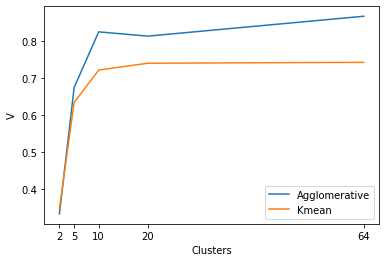

In [137]:
v_agglomerative = np.array(v_agglomerative) 
v_kmean = np.array(v_kmean) 

k_max_agglomerative = v_agglomerative[:,0][np.where(v_agglomerative == np.amax(v_agglomerative[:,1].max()))[0][0]]
k_max_kmean = v_kmean[:,0][np.where(v_kmean == np.amax(v_kmean[:,1].max()))[0][0]]

print('V max from agglomerative: {}'.format(int(k_max_agglomerative)))
print('V max from kmean: {}'.format(int(k_max_kmean)))

plt.plot(v_agglomerative[:,0], v_agglomerative[:,1], label='Agglomerative' )
plt.plot(v_kmean[:,0], v_kmean[:,1], label='Kmean')
plt.xlabel('Clusters')
plt.xticks(COMPONENTS)
plt.ylabel('V')
plt.legend()

In [ ]:
We have no increace V but for kmean we have the same value when decreasing d = 10

silhouette max from agglomerative: 2
silhouette max from kmean: 2


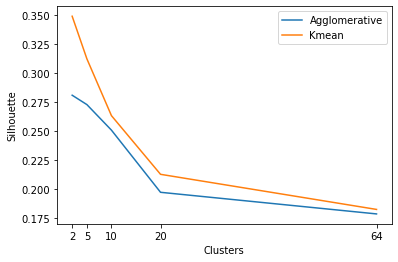

In [138]:
silhouette_agglomerative = np.array(silhouette_agglomerative) 
silhouette_kmean = np.array(silhouette_kmean) 

k_max_agglomerative = silhouette_agglomerative[:,0][np.where(silhouette_agglomerative == np.amax(silhouette_agglomerative[:,1].max()))[0][0]]
k_max_kmean = silhouette_kmean[:,0][np.where(silhouette_kmean == np.amax(silhouette_kmean[:,1].max()))[0][0]]

print('silhouette max from agglomerative: {}'.format(int(k_max_agglomerative)))
print('silhouette max from kmean: {}'.format(int(k_max_kmean)))

plt.plot(silhouette_agglomerative[:,0], silhouette_agglomerative[:,1], label='Agglomerative' )
plt.plot(silhouette_kmean[:,0], silhouette_kmean[:,1], label='Kmean')
plt.xlabel('Clusters')
plt.xticks(COMPONENTS)
plt.ylabel('Silhouette')
plt.legend()

In [ ]:
We have decrease silhouette if d increasing

Другая популярная техника снижения размерности, которая особенно хорошо подходит для работы с картинками, – это алгоритм t-distributed stochastic neighbor embeddings, сокращённо tSNE. В отличие от сингулярного разложения, это преобразование нелинейное. Его основная идея – отобразить точки из пространства размерности $d$ в пространство размерности 2 или 3 (обычно 2, то есть на плоскость) таким образом, чтобы как можно точнее сохранить расстояния. Математические детали есть, например, [здесь](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), но они нетривиальны.

В библиотеке scikit-learn реализацией tSNE является класс `TSNE` в подмодуле `manifold`. В конструктор можно передать параметр `n_components`, а можно и не передавать: по умолчанию он равен 2. Метод `fit_transform` работает аналогично тому, как и у `TruncatedSVD`.

<u>Замечание:</u> В последние годы вместо tSNE на практике часто используется [UMAP](https://github.com/lmcinnes/umap), более быстрый алгоритм с похожими свойствами. В этой лабораторной работе не предлагается использовать UMAP, так как это потребовало бы установить ещё одну зависимость -- библиотеку `umap-learn`. Желающие могут проделать задания на tSNE с использованием UMAP; в этом случае обратите внимание на параметры `n_neighbors` и `min_dist`, которыми определяется вид проекции.

**(0.5 балла)** Выполните tSNE-преобразование матрицы `X`, оставив 2 признака. Визуализируйте данные, преобразованные таким образом, в виде точечной диаграммы: первый признак вдоль горизонтальной оси, второй признак вдоль вертикальной оси. Подсветите разными цветами группы точек, соответствующих разным цифрам.

*Указания:*
- Точечную диаграмму умеет рисовать функция `plt.scatter`. Ознакомьтесь со справкой к ней.
- За цвета точек отвечает параметр `c` у функции `plt.scatter`. Передать в него надо истинные метки классов.

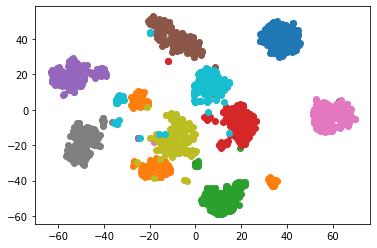

In [10]:
from sklearn.manifold import TSNE

CLUSTERS = 10
COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

X_trunc = TSNE().fit_transform(X)
df = pd.DataFrame({'x':X_trunc[:,0], 'y':X_trunc[:,1], 'num':y})

for i in range(0, CLUSTERS):
    plt.scatter(df[df['num'] == i]['x'], df[df['num'] == i]['y'],  c = COLORS[i])




**(1 балл)** Для tSNE-преобразованных данных с 2 признаками выполните иерархическую и $K$-means кластеризацию (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [144]:
clustering_agglomerative_original = AgglomerativeClustering(n_clusters=CLUSTERS).fit_predict(X)
v_agglomerative_original          = v_measure_score(y, clustering_agglomerative_original)
silhouette_agglomerative_original = silhouette_score(X, clustering_agglomerative_original)

clustering_kmean_original = KMeans(n_clusters=CLUSTERS, n_init=100).fit_predict(X)
v_kmean_original          = v_measure_score(y, clustering_kmean_original)
silhouette_kmean_original = silhouette_score(X, clustering_kmean_original)
    
clustering_kmean = KMeans(n_clusters=CLUSTERS, n_init=100).fit_predict(X_trunc)
v_kmean          = v_measure_score(y, clustering_kmean)
silhouette_kmean = silhouette_score(X_trunc, clustering_kmean)

clustering_agglomerative = AgglomerativeClustering(n_clusters=CLUSTERS).fit_predict(X_trunc)
v_agglomerative          = v_measure_score(y, clustering_agglomerative)
silhouette_agglomerative = silhouette_score(X_trunc, clustering_agglomerative)
    


In [146]:
print('Silhouettes:')
print('Original agglomerative: {}, clustering_agglomerative: {}'. format(silhouette_agglomerative_original, silhouette_agglomerative))
print('Original kmean: {}, clustering_kmean: {}'. format(silhouette_kmean_original, silhouette_kmean))

print('\nV:')
print('Original agglomerative: {}, clustering_agglomerative: {}'. format(v_agglomerative_original, v_agglomerative))
print('Original kmean: {}, clustering_kmean: {}'. format(v_kmean_original, v_kmean))


Silhouettes:
Original agglomerative: 0.17849659940596496, clustering_agglomerative: 0.17849659940596496
Original kmean: 0.18236087870891401, clustering_kmean: 0.1824333098053679

V:
Original agglomerative: 0.8681701126909083, clustering_agglomerative: 0.8681701126909083
Original kmean: 0.7424974399472629, clustering_kmean: 0.7432313881731174


**(0.5 балла)** Для самого лучшего разбиения, которое вам удалось получить (на ваше усмотрение, лучшего в терминах силуэта или $V$-меры), опять визуализируйте картинками центры кластеров. Удалось ли добиться, чтобы каждый кластер соответствовал какой-нибудь одной цифре?

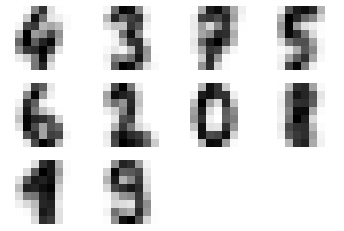

In [197]:
CLUSTERS = 10
MAX_X_SUBPLOTS = 3
MAX_Y_SUBPLOTS = 4
X_mean = {}

for i in range(0,CLUSTERS):
    mask_kmean = (clustering_kmean == i)
    X_mean[i] = np.mean(X[mask_kmean], axis=0).reshape((8, 8))    

img_for_visual = X_mean
fig, axs = plt.subplots(MAX_X_SUBPLOTS, MAX_Y_SUBPLOTS)

curr_img_count = 0
for i in range(0, MAX_X_SUBPLOTS):
    for j in range (0, MAX_Y_SUBPLOTS):
        axs[i, j].set_axis_off()
        if (curr_img_count < MAX_IMG_COUNT):
            axs[i, j].imshow(img_for_visual[curr_img_count], cmap=plt.cm.gray_r, interpolation='nearest')
            curr_img_count += 1

# 4. Итоги, бонус

**(1 балл)** Напишите в свободной форме, какие выводы вы сделали из выполненной работы. Ответьте, как минимум, на следующие два вопроса:
- Какой из двух методов даёт более осмысленные кластеры – иерархическая кластеризация или алгоритм $K$ средних? Зависит ли это от настроек каждого алгоритма? От критериев оценивания качества?
- Удаётся ли улучшить качество кластеризации, снижая размерность признакового пространства?

In [ ]:
1. Depending on the initial settings, quality assessment, input data, the best clustering can be given by both the 𝐾 averages algorithm and
agglomerative clustering. 
2. According test above Silhouettes and V can increase after reducing the dimension of the feature space.

**(Бонусные 2 балла)** Скачайте датасет [MNIST Handwritten Digits](http://yann.lecun.com/exdb/mnist). Как сделать это с помощью scikit-learn, написано [здесь](https://stackoverflow.com/a/60450028). MNIST Handwritten Digits – это 70 тысяч распознанных рукописных изображений цифр, каждое размером 28 $\times$ 28 пикселей. Попробуйте прокластеризовать этот датасет и добиться как можно лучших значений силуэта и $V$-меры.

In [26]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
CLUSTERS = 10

In [29]:
clustering_kmean = KMeans(n_clusters=CLUSTERS, n_init=100).fit_predict(X)
v_kmean          = v_measure_score(y, clustering_kmean)
silhouette_kmean = silhouette_score(X, clustering_kmean)

In [30]:
print('silhouette_kmean: {}'. format( silhouette_kmean))
print('v_kmean: {}'. format(v_kmean))

silhouette_kmean: 0.05874478369919512
v_kmean: 0.4998945961562201


In [12]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import v_measure_score

X_trunc = TSNE().fit_transform(X)
X_trunc.shape


(70000, 2)

In [14]:
clustering_kmean = KMeans(n_clusters=CLUSTERS, n_init=100).fit_predict(X_trunc)
v_kmean          = v_measure_score(y, clustering_kmean)
silhouette_kmean = silhouette_score(X_trunc, clustering_kmean)

In [16]:
print('silhouette_kmean: {}'. format( silhouette_kmean))
print('v_kmean: {}'. format(v_kmean))

silhouette_kmean: 0.384599506855011
v_kmean: 0.7697928342150158
